# [COM6513] Assignment 1: Sentiment Analysis with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test a **text classification** system for **sentiment analysis**, in particular to predict the sentiment of movie reviews, i.e. positive or negative (binary classification).



For that purpose, you will implement:


- Text processing methods for extracting Bag-Of-Word features, using 
    - n-grams (BOW), i.e. unigrams, bigrams and trigrams to obtain vector representations of documents where n=1,2,3 respectively. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). 
    - character n-grams (BOCN). A character n-gram is a contiguous sequence of characters given a word, e.g. for n=2, 'coffee' is split into {'co', 'of', 'ff', 'fe', 'ee'}. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). **Tip: Note the large vocabulary size!** 
    - a combination of the two vector spaces (n-grams and character n-grams) choosing your best performing wighting respectively (i.e. raw or tfidf). (**1 mark**) **Tip: you should merge the two representations**



- Binary Logistic Regression (LR) classifiers that will be able to accurately classify movie reviews trained with: 
    - (1) BOW-count (raw frequencies) 
    - (2) BOW-tfidf (tf.idf weighted)
    - (3) BOCN-count
    - (4) BOCN-tfidf
    - (5) BOW+BOCN (best performing weighting; raw or tfidf)



- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function (**1 mark**)
    - Use L2 regularisation (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous development loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)



- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength) for each LR model? You should use a table showing model performance using different set of hyperparameter values. (**2 marks). **Tip: Instead of using all possible combinations, you could perform a random sampling of combinations.**


- After training each LR model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot. Does your model underfit, overfit or is it about right? Explain why. (**1 mark**). 


- Identify and show the most important features (model interpretability) for each class (i.e. top-10 most positive and top-10 negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!). If you were to apply the classifier into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**2 marks**). 


- Provide efficient solutions by using Numpy arrays when possible (you can find tips in Lab 1 sheet). Executing the whole notebook with your code should not take more than 5 minutes on a any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs (**2 marks**). 






### Data 

The data you will use are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.




### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex` or you can print it as PDF using your browser).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 14 Mar 2022** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
train_data = pd.read_csv('data_sentiment/train.csv', encoding= 'unicode_escape',names=['text','lable'])
val_data = pd.read_csv('data_sentiment/dev.csv', encoding= 'unicode_escape',names=['text','lable'])
test_data = pd.read_csv('data_sentiment/test.csv', encoding= 'unicode_escape',names=['text','lable'])

train_data.describe()

,lable
count,1400.000000
mean,0.500000
std,0.500179
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


If you use Pandas you can see a sample of the data.

In [3]:
train_data.sample(5)

,text,lable
952,you know that a movie has issues when most eve...,0
908,"while watching loser , it occurred to me that ...",0
221,"richard gere can be a commanding actor , but h...",1
310,"though it is a fine piece of filmmaking , ther...",1
218,if there is one thing that bothers me about ho...,1


The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [4]:
train_data_text = train_data['text'].tolist()
Y_tr = train_data['lable'].to_numpy()

val_data_text = val_data['text'].tolist()
Y_dev = val_data['lable'].to_numpy()

test_data_text = test_data['text'].tolist()
Y_te = test_data['lable'].to_numpy()

len(val_data_text)

200

# Vector Representations of Text 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams (or character ngrams from the unigrams)
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (or character n-grams). You can keep top N if you encounter memory issues.


In [5]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `char_ngrams`: boolean. If true the function extracts character n-grams

and returns:

- `x': a list of all extracted features.

See the examples below to see how this function should work.

In [6]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'', 
                   stop_words=[], vocab=set(), char_ngrams=False):
    
    x = []
    
    split_text = re.split(r'\W+',x_raw)
    for word in split_text:
        if word in stop_words:
            split_text.remove(word)
            if(word == ''):
                split_text.remove(word)

    if(char_ngrams == False):
        if len(vocab)>0:
            for i,word in enumerate(split_text):
                for j in range(ngram_range[0],ngram_range[1]+1):
                    if(i+j<=len(split_text)):
                        temp_word = ' '.join(split_text[i:i+j])
                        if temp_word in vocab:
                            x.append(temp_word)
        else:
            for i,word in enumerate(split_text):
                for j in range(ngram_range[0],ngram_range[1]+1):
                    if(i+j<=len(split_text)):
                        x.append(' '.join(split_text[i:i+j]))       

    else:
        text = ''.join(split_text)
        split_text = re.split(r'\W*', text)
        split_text.remove(split_text[0])
        split_text.remove(split_text[-1])
        if len(vocab)>0:
            for i,char in enumerate(split_text):
                for j in range(ngram_range[0],ngram_range[1]+1):
                    if(i+j<=len(split_text)):
                        temp_char = ''.join(split_text[i:i+j])
                        if temp_char in vocab:
                            x.append(temp_char)
        
        else:
            for i,char in enumerate(split_text):
                for j in range(ngram_range[0],ngram_range[1]+1):
                    if(i+j<=len(split_text)):
                        x.append(''.join(split_text[i:i+j]))
        
    return x

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

For extracting character n-grams the function should work as follows:

In [7]:
extract_ngrams("movie good", 
               ngram_range=(2,4), 
               stop_words=[],
               char_ngrams=True)

['mo',
 'mov',
 'movi',
 'ov',
 'ovi',
 'ovie',
 'vi',
 'vie',
 'vieg',
 'ie',
 'ieg',
 'iego',
 'eg',
 'ego',
 'egoo',
 'go',
 'goo',
 'good',
 'oo',
 'ood',
 'od']

### Create a vocabulary 

The `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [8]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'', 
              min_df=0, keep_topN=0, 
              stop_words=[],char_ngrams=False):
    
    df = []
    df_save =[]
    ngram_counts_temp = []
    vocab = []

    for text in X_raw:
        docs = extract_ngrams(text,ngram_range,stop_words =stop_words,char_ngrams=char_ngrams)
        ngram_counts_temp.append(docs)
        df_save.append(set(docs)) 

    df_save = [i for k in df_save for i in k]
    ngram_counts_temp = [i for k in ngram_counts_temp for i in k]
    ngram_counts = Counter(ngram_counts_temp)
    temp = Counter(df_save)
    for ngram,num in dict(temp).items():
        if num < min_df:
            temp.pop(ngram)
            ngram_counts.pop(ngram)
        if num == len(X_raw):
            temp.pop(ngram)
            ngram_counts.pop(ngram)
    df=temp
    vocab=list(df.keys())
    
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [9]:
ngram_range=(1,3)
min_df = 50
char_ngrams=False
vocab_w,df_w,ngram_counts_w = get_vocab(train_data_text, ngram_range=ngram_range, min_df=min_df,keep_topN=0,stop_words=stop_words,char_ngrams=char_ngrams)
len(vocab_w)
# (1,3) word 20 5421
# (1,3) word 50 2034
#(2,4) char 50 18060
#(2,4) char 100 11038

2036

In [177]:
ngram_range=(3,4)
min_df = 700
char_ngrams=True
vocab_c,df_c,ngram_counts_c = get_vocab(train_data_text, ngram_range=ngram_range, min_df=min_df,keep_topN=0,stop_words=stop_words,char_ngrams=char_ngrams)
len(vocab_c)

1004

Then, you need to create 2 dictionaries: (1) vocabulary id -> word; and  (2) word -> vocabulary id so you can use them for reference:

In [11]:
def createDict(vocab):
    id2word = dict()
    word2id = dict()
    for i,voc in enumerate(vocab):
        id2word[i] = voc
        word2id[voc] = i
    return id2word,word2id

In [12]:
id2word,word2id = createDict(vocab_w)

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [13]:
def ext_all_ngrams(train,val,test,ngram_test_ch,char_ngrams,stop_words,vocab,char_ngrams):
    ngram_train=[]
    ngram_val=[]
    ngram_test=[]
    for text in train:
        docs = extract_ngrams(text,ngram_range,stop_words = stop_words,vocab = vocab_w,char_ngrams=char_ngrams)
        ngram_train.append(docs)
    for text in val:
        docs = extract_ngrams(text,ngram_range,stop_words = stop_words,vocab = vocab_w,char_ngrams=char_ngrams)
        ngram_val.append(docs)
    for text in test:
        docs = extract_ngrams(text,ngram_range,stop_words = stop_words,vocab = vocab_w,char_ngrams=char_ngrams)
        ngram_test.append(docs)
    return ngram_train,ngram_val,ngram_test

In [178]:
ngram_train_ch=[]
ngram_val_ch=[]
ngram_test_ch=[]
ngram_range=(3,4)
char_ngrams=True
for text in train_data_text:
    docs = extract_ngrams(text,ngram_range,stop_words = stop_words,vocab = vocab_c,char_ngrams=char_ngrams)
    ngram_train_ch.append(docs)
for text in val_data_text:
    docs = extract_ngrams(text,ngram_range,stop_words = stop_words,vocab = vocab_c,char_ngrams=char_ngrams)
    ngram_val_ch.append(docs)
for text in test_data_text:
    docs = extract_ngrams(text,ngram_range,stop_words = stop_words,vocab = vocab_c,char_ngrams=char_ngrams)
    ngram_test_ch.append(docs)
    

In [179]:
X_tr_count_c = vectorise(ngram_train_ch,vocab_c)
X_dev_count_c = vectorise(ngram_val_ch,vocab_c)
X_te_count_c = vectorise(ngram_test_ch,vocab_c)

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [14]:
def vectorise(X_ngram, vocab):
    rows, cols = len(X_ngram),len(vocab)
    X_vec = [([]*cols) for i in range(rows)]
    for i,doc in enumerate(X_ngram):
        doc_fre = Counter(doc)
        for j,word in enumerate(vocab):
            if doc_fre[word]>0:
                X_vec[i].append(doc_fre[word])
            else:
                X_vec[i].append(0)
    X_vec = np.squeeze(np.asarray(X_vec))
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [15]:
def vec_all_data(ngram_train,ngram_val,ngram_test,vocab)
    X_tr = vectorise(ngram_train,vocab)
    X_dev = vectorise(ngram_val,vocab)
    X_te = vectorise(ngram_test,vocab)
    return X_tr,X_dev,X_te

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [16]:
idf_dict = dict()

for word in vocab_w:
    idf_dict[word] = np.log10(np.shape(X_tr_count)[0]/df_w[word])

Then transform your count vectors to tf.idf vectors:

In [17]:
idf_list = list(idf_dict.values())
idf_arr = np.array(idf_list)

X_tr_tfidf = X_tr_count * idf_arr
X_dev_tfidf = X_dev_count*idf_arr
X_te_tfidf = X_te_count*idf_arr

In [ ]:
def vec_tfidf(X_tr_count,X_dev_count,X_te_count,vocab,df):
    idf_dict = dict()

    for word in vocab:
        idf_dict[word] = np.log10(np.shape(X_tr_count)[0]/df[word])
    
    idf_list = list(idf_dict.values())
    idf_arr = np.array(idf_list)

    X_tr_tfidf = X_tr_count * idf_arr
    X_dev_tfidf = X_dev_count*idf_arr
    X_te_tfidf = X_te_count*idf_arr
    
    return X_tr_tfidf,X_dev_tfidf,X_te_tfidf

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [19]:
def sigmoid(z):
    
    sig = 1/(1+np.exp(-z))
    
    return sig

Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [20]:
def predict_proba(X, weights):
    
    preds_proba = sigmoid(weights@X.T) 
    
    return preds_proba

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [21]:
def predict_class(X, weights):
    y = weights@(X.T)
    y_class = []
    for p in y:
        if(p>0.5):
            y_class.append(1)
        else:
            y_class.append(0)
    return np.array(y_class)

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [22]:
def binary_loss(X, Y, Y_pre, weights, alpha=0.00001):
    '''
    Binary Cross-entropy Loss

    X:(len(X),len(vocab))
    Y: array len(Y)
    weights: array len(X)
    '''
    l = (-Y*np.log(Y_pre)-(1-Y)*np.log(1-Y_pre)).mean()+alpha*np.dot(weights.T,weights)

    return l

# attention: derivation of W?

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [100]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], lr=0.000001, 
        alpha=0.000001, epochs=300, 
        tolerance = 0.0000001, print_progress=True):
    
    last_val_loss = 1e+3
    training_loss_history = []
    validation_loss_history = []
    weights = np.zeros(np.shape(X_tr)[1])
    Y_tr_pre = np.zeros(np.shape(X_tr)[0])
    for i in range(epochs):
        indices = np.array(range(len(X_tr)))
        np.random.shuffle(indices)
        for index in indices:
            Y_tr_pre[index] = predict_proba(X_tr[index],weights)
            weights -= lr*((Y_tr_pre[index] - Y_tr[index])*X_tr[index] + 2*alpha*weights)
        
        training_loss_history.append([i,binary_loss(X_tr,Y_tr,Y_tr_pre,weights,alpha)]) 
        Y_dev_pre = predict_proba(X_dev,weights)
        validation_loss_history.append([i,binary_loss(X_dev,Y_dev,Y_dev_pre,weights,alpha)])
        if print_progress == True:
            if (i+1)%200 ==0:
                print("Epoch: {}. Training_Loss: {:.6f}. Val_Loss: {:.6f}".format((i+1),training_loss_history[i][1],validation_loss_history[i][1]))
        if (last_val_loss-validation_loss_history[i][1]) < tolerance:
            break
        last_val_loss = validation_loss_history[i][1]
        
    
    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [153]:
lr = 0.000002    #0.000002 f 2036
alpha = 0.001
epochs = 3000
tolerance = 0.000001
w_count, training_loss_history, validation_loss_history = SGD(X_tr_count,Y_tr,X_dev_count,Y_dev,lr,alpha,epochs,tolerance)

Epoch: 200. Training_Loss: 0.522261. Val_Loss: 0.566101
Epoch: 400. Training_Loss: 0.457147. Val_Loss: 0.520693
Epoch: 600. Training_Loss: 0.414972. Val_Loss: 0.492156
Epoch: 800. Training_Loss: 0.384036. Val_Loss: 0.472119


In [186]:
lr = 0.00000015    # char count
alpha = 0.001
epochs = 3000
tolerance = 0.000001
c_count, training_loss_history_cc, validation_loss_history_cc = SGD(X_tr_count_c,Y_tr,X_dev_count_c,Y_dev,lr,alpha,epochs,tolerance)

Epoch: 200. Training_Loss: 0.616030. Val_Loss: 0.628767
Epoch: 400. Training_Loss: 0.573365. Val_Loss: 0.599811
Epoch: 600. Training_Loss: 0.543130. Val_Loss: 0.581893
Epoch: 800. Training_Loss: 0.519701. Val_Loss: 0.569343
Epoch: 1000. Training_Loss: 0.500646. Val_Loss: 0.559990
Epoch: 1200. Training_Loss: 0.484627. Val_Loss: 0.552725
Epoch: 1400. Training_Loss: 0.470836. Val_Loss: 0.546940
Epoch: 1600. Training_Loss: 0.458749. Val_Loss: 0.542257
Epoch: 1800. Training_Loss: 0.448004. Val_Loss: 0.538429
Epoch: 2000. Training_Loss: 0.438344. Val_Loss: 0.535282
Epoch: 2200. Training_Loss: 0.429575. Val_Loss: 0.532686
Epoch: 2400. Training_Loss: 0.421555. Val_Loss: 0.530540
Epoch: 2600. Training_Loss: 0.414170. Val_Loss: 0.528775
Epoch: 2800. Training_Loss: 0.407333. Val_Loss: 0.527345


In [160]:
X_tr_tfidf
lr = 0.00001    #0.000002 f 2036
alpha = 0.001
epochs = 3000
tolerance = 0.000001
w_tfidf, training_loss_history_wt, validation_loss_history_wt = SGD(X_tr_tfidf,Y_tr,X_dev_tfidf,Y_dev,lr,alpha,epochs,tolerance)

Epoch: 200. Training_Loss: 0.417658. Val_Loss: 0.512450
Epoch: 400. Training_Loss: 0.326675. Val_Loss: 0.457029
Epoch: 600. Training_Loss: 0.275609. Val_Loss: 0.428348
Epoch: 800. Training_Loss: 0.241684. Val_Loss: 0.411094
Epoch: 1000. Training_Loss: 0.217099. Val_Loss: 0.399948
Epoch: 1200. Training_Loss: 0.198296. Val_Loss: 0.392467
Epoch: 1400. Training_Loss: 0.183375. Val_Loss: 0.387359
Epoch: 1600. Training_Loss: 0.171214. Val_Loss: 0.383865
Epoch: 1800. Training_Loss: 0.161099. Val_Loss: 0.381513
Epoch: 2000. Training_Loss: 0.152550. Val_Loss: 0.379985
Epoch: 2200. Training_Loss: 0.145231. Val_Loss: 0.379077


Now plot the training and validation history per epoch for the best hyperparameter combination. Does your model underfit, overfit or is it about right? Explain why.

In [193]:
def show_loss(train_loss,val_loss,t):
    training_loss_history = np.array(train_loss)
    validation_loss_history = np.array(val_loss)

    x1 = training_loss_history[:,0]
    y1 = training_loss_history[:,1]
    x2 = validation_loss_history[:,0]
    y2 = validation_loss_history[:,1]

    fig = plt.figure(figsize = (7,5))       

    p1 = plt.plot(x1, y1,'g-', label = u'Train Loss')
    plt.legend()

    p2 = plt.plot(x2, y2, 'b-', label = u'Val Loss')
    plt.legend()
    plt.xlabel(u'Epochs')
    plt.ylabel(u'Loss')
    plt.title('Compare loss for {}'.format(t))
    

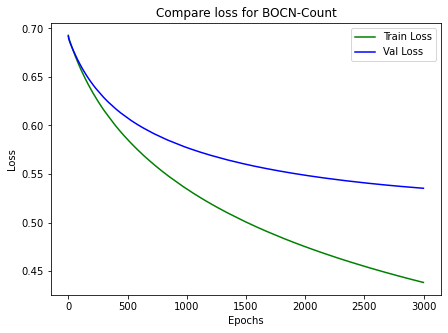

In [194]:
t = 'BOCN-Count'
show_loss(training_loss_history,validation_loss_history,t)

Text(0.5, 1.0, 'Compare loss for different dataset')

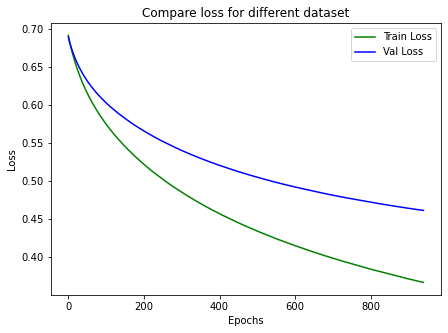

In [154]:
training_loss_history = np.array(training_loss_history)
validation_loss_history = np.array(validation_loss_history)

x1 = training_loss_history[:,0]
y1 = training_loss_history[:,1]
x2 = validation_loss_history[:,0]
y2 = validation_loss_history[:,1]

fig = plt.figure(figsize = (7,5))       
ax1 = fig.add_subplot(1, 1, 1) 

p2 = plt.plot(x1, y1,'g-', label = u'Train Loss')
plt.legend()

p3 = plt.plot(x2, y2, 'b-', label = u'Val Loss')
plt.legend()
plt.xlabel(u'Epochs')
plt.ylabel(u'Loss')
plt.title('Compare loss for different dataset')


Explain here...

#### Evaluation

Compute accuracy, precision, recall and F1-scores:

In [ ]:
def evaluation(X_te,Y_te,W):
    preds_te = predict_class(X_te, W)

    print('Accuracy:', accuracy_score(Y_te,preds_te))
    print('Precision:', precision_score(Y_te,preds_te))
    print('Recall:', recall_score(Y_te,preds_te))
    print('F1-Score:', f1_score(Y_te,preds_te))

In [155]:

preds_te_count = predict_class(X_te_count, w_count)

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.815
Precision: 0.9038461538461539
Recall: 0.705
F1-Score: 0.7921348314606741


In [162]:
preds_te_tfidf = predict_class(X_te_tfidf, w_tfidf)

print('Accuracy:', accuracy_score(Y_te,preds_te_tfidf))
print('Precision:', precision_score(Y_te,preds_te_tfidf))
print('Recall:', recall_score(Y_te,preds_te_tfidf))
print('F1-Score:', f1_score(Y_te,preds_te_tfidf))

Accuracy: 0.8575
Precision: 0.8783068783068783
Recall: 0.83
F1-Score: 0.8534704370179949


In [187]:

preds_te_count_c = predict_class(X_te_count_c, c_count)

print('Accuracy:', accuracy_score(Y_te,preds_te_count_c))
print('Precision:', precision_score(Y_te,preds_te_tfidf))
print('Recall:', recall_score(Y_te,preds_te_count_c))
print('F1-Score:', f1_score(Y_te,preds_te_count_c))

Accuracy: 0.7825
Precision: 0.8783068783068783
Recall: 0.66
F1-Score: 0.752136752136752


Finally, print the top-10 words for the negative and positive class respectively.

In [152]:
lr

2e-06

In [27]:
top_neg = w_count.argsort()[:10]
for i in top_neg:
    print(id2word[i])

bad
only
worst
unfortunately
plot
script
boring
nothing
why
any


In [28]:
top_pos = w_count.argsort()[::-1][:10]
for i in top_pos:
    print(id2word[i])

great
well
also
seen
movies
world
fun
both
many
life


If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

Provide your answer here...

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

Enter your answer here...

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


### Now repeat the training and evaluation process for BOW-tfidf, BOCN-count, BOCN-tfidf, BOW+BOCN including hyperparameter tuning for each model...

In [196]:
def myLRmodal_count(X_tr, Y_tr, X_dev,Y_dev,X_te,ngram_range,min_df,keep_topN,
                    stop_words,char_ngrams,lr,alpha,print_progress):
    
    vocab,df,ngram_counts = get_vocab(X_tr, ngram_range=ngram_range, min_df=min_df,
                                      keep_topN=0,stop_words=stop_words,char_ngrams=char_ngrams)
    
    ngram_tr,ngram_dev,ngram_te = ext_all_ngrams(X_tr,Y_tr,X_te) # lack of para
    
    x_tr_count,x_dev_count,x_te_count = vec_all_data(ngram_tr,ngram_dev,ngram_te,vocab)
   
    weights,train_loss,val_loss = SGD(x_tr,y_tr,x_dev,y_dev, lr=lr, alpha=alpha, 
                                      epochs=epochs,tolerance = tolerance, print_progress=print_progress)
    
    evaluation(X_te,Y_te,W)
    
    show_loss(train_loss,val_loss,t)
    
    return x_tr_count,x_dev_count,x_te_count,vocab,df


In [198]:
def myLRmodal_tfidf(x_tr_count,Y_tr,x_dev_count,Y_dev,x_te_count,vocab,df,ngram_range,
                    min_df,keep_topN,stop_words,char_ngrams,lr,alpha,print_progress):
    
    X_tr_tfidf,X_dev_tfidf,X_te_tfidf = vec_tfidf(X_tr_count,X_dev_count,X_te_count,vocab,df)
    
    weights,train_loss,val_loss = SGD(x_tr,y_tr,x_dev,y_dev, lr=lr, alpha=alpha, 
                                      epochs=epochs,tolerance = tolerance, print_progress=print_progress)
    
    evaluation(X_te,Y_te,W)
    
    show_loss(train_loss,val_loss,t)  
    

In [197]:
# BOW-tfidf





## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |   |   |   |
| BOW-tfidf  |   |   |   |
| BOCN-count  |   |   |   |
| BOCN-tfidf  |   |   |   |
| BOW+BOCN  |   |   |   |

Please discuss why your best performing model is better than the rest.